In [ ]:
import nltk; nltk.download('stopwords')

!python -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

!python -m pip install -U pyLDAvis

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

     |████████████████████████████████| 1.6MB 2.9MB/s 
     |████████████████████████████████| 552kB 56.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=65dba15596071cfc07e9e85a80bcbd48da5534e823ded9ab86079492dc3248df
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=0b7c6f6c934447a63c210c6d4701a80d93bb04787fc11572aa9db89656ccba1d
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [ ]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]]


#TOPIC MODELLING LDA

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"team" + 0.036*"game" + 0.020*"sale" + 0.019*"play" + 0.015*"hockey" '
  '+ 0.012*"year" + 0.008*"nhl" + 0.008*"trade" + 0.008*"wing" + '
  '0.007*"steven"'),
 (1,
  '0.040*"book" + 0.020*"belief" + 0.020*"atheist" + 0.018*"church" + '
  '0.015*"pin" + 0.015*"slave" + 0.014*"sphere" + 0.012*"character" + '
  '0.010*"lord" + 0.009*"headache"'),
 (2,
  '0.015*"choose" + 0.012*"input" + 0.011*"sin" + 0.010*"notice" + 0.009*"eat" '
  '+ 0.009*"cd" + 0.009*"food" + 0.009*"material" + 0.008*"signal" + '
  '0.008*"external"'),
 (3,
  '0.035*"not" + 0.022*"write" + 0.022*"do" + 0.020*"would" + 0.020*"line" + '
  '0.019*"organization" + 0.017*"be" + 0.017*"article" + 0.014*"get" + '
  '0.014*"know"'),
 (4,
  '0.533*"ax" + 0.008*"rlk" + 0.006*"cub" + 0.005*"echo" + '
  '0.004*"tufts_university" + 0.004*"stl" + 0.004*"pitcher" + 0.004*"pit" + '
  '0.004*"lk" + 0.003*"differential"'),
 (5,
  '0.027*"israel" + 0.015*"israeli" + 0.011*"jew" + 0.009*"lebanese" + '
  '0.009*"arab" + 0.00

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.732797516655772

Coherence Score:  0.5017680246997409


#VISUALIZATION

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

![alt text](https://www.machinelearningplus.com/wp-content/uploads/2018/03/pyLDAvis.png)

# TOPIC MODELLING ON MALLET

In [ ]:
!pip install --upgrade gensim

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.5" 2019-10-15
OpenJDK Runtime Environment (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04)
OpenJDK 64-Bit Server VM (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04, mixed mode, sharing)


In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '\Users\Tanya\Downloads\mallet-2.0.8\mallet-2.0.8\bin\mallet.bat' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CalledProcessError: ignored

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

NameError: ignored

In [ ]:
%%time
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [ ]:
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

CPU times: user 1h 12min 19s, sys: 12min 51s, total: 1h 25min 10s
Wall time: 1h 10min 40s


#OPTIMAL MODEL

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.011*"team" + 0.011*"game" + 0.009*"space" + 0.007*"year" + 0.006*"win" + '
  '0.006*"play" + 0.005*"player" + 0.005*"university" + 0.005*"line" + '
  '0.005*"hockey"'),
 (1,
  '0.007*"patient" + 0.006*"armenian" + 0.005*"greek" + 0.005*"publish" + '
  '0.004*"character" + 0.004*"report" + 0.004*"disease" + 0.004*"turk" + '
  '0.004*"child" + 0.003*"health"'),
 (2,
  '0.016*"line" + 0.013*"organization" + 0.008*"use" + 0.007*"system" + '
  '0.007*"drive" + 0.006*"host" + 0.006*"thank" + 0.006*"university" + '
  '0.005*"get" + 0.005*"window"'),
 (3,
  '0.022*"not" + 0.013*"do" + 0.011*"write" + 0.011*"be" + 0.011*"would" + '
  '0.010*"go" + 0.010*"article" + 0.009*"get" + 0.009*"organization" + '
  '0.009*"line"'),
 (4,
  '0.313*"ax" + 0.026*"_" + 0.024*"max" + 0.005*"cx" + 0.004*"rlk" + '
  '0.004*"md" + 0.004*"c" + 0.004*"mv" + 0.003*"te" + 0.003*"mk"'),
 (5,
  '0.013*"god" + 0.009*"say" + 0.009*"people" + 0.008*"evidence" + 0.007*"not" '
  '+ 0.007*"may" + 0.006*"reason" + 0

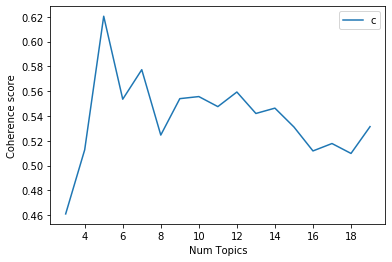

In [ ]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
%%time
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


CPU times: user 1min 39s, sys: 1.63 s, total: 1min 41s
Wall time: 1min 40s


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9924,"team, game, space, year, win, play, player, university, line, hockey","Subject: NHL Summary parse results for games played Sat, April 3, 1993 From: (COOK Charlie) Orga..."
1,1.0,0.8147,"patient, armenian, greek, publish, character, report, disease, turk, child, health","From: (Serdar Argic) Subject: Armenian slaughter of more than 600,000 Kurdish people in 1915. Re..."
2,2.0,0.9838,"line, organization, use, system, drive, host, thank, university, get, window",Subject: Trident 8900 switch settings (someone archive this!) From: Organization: Mankato State ...
3,3.0,0.9701,"not, do, write, be, would, go, article, get, organization, line",From: (C. D. Tavares) Subject: Re: Rewording the Second Amendment (ideas) Organization: Stratus ...
4,4.0,0.9997,"ax, _, max, cx, rlk, md, c, mv, te, mk",Subject: roman.bmp 13/14 From: (Cliff) Reply-To: (Cliff) Distribution: usa Organization: Univers...
5,5.0,0.9420,"god, say, people, evidence, not, may, reason, christian, believe, write",From: (Kent Sandvik) Subject: Re: Free Moral Agency and Kent S. Organization: Cookamunga Tourist...


#RESULT ON NEWSGROUP

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"not, do, write, be, would, go, article, get, organization, line",650.0,0.0575
1.0,2.0,"line, organization, use, system, drive, host, thank, university, get, window",278.0,0.0246
2.0,3.0,"not, do, write, be, would, go, article, get, organization, line",4199.0,0.3711
3.0,2.0,"line, organization, use, system, drive, host, thank, university, get, window",4610.0,0.4075
4.0,2.0,"line, organization, use, system, drive, host, thank, university, get, window",26.0,0.0023
...,...,...,...,...
11309.0,3.0,"not, do, write, be, would, go, article, get, organization, line",NaN,NaN
11310.0,2.0,"line, organization, use, system, drive, host, thank, university, get, window",NaN,NaN
11311.0,2.0,"line, organization, use, system, drive, host, thank, university, get, window",NaN,NaN
11312.0,2.0,"line, organization, use, system, drive, host, thank, university, get, window",NaN,NaN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#LSA Topic Modeling


In [ ]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [ ]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [ ]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])
X.shape # check shape of the document-term matrix

(11314, 1000)

In [ ]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
like
 
know
 
people
 
think
 
good
 
time
 
thanks
 
Topic 1: 
thanks
 
windows
 
card
 
drive
 
mail
 
file
 
advance
 
Topic 2: 
game
 
team
 
year
 
games
 
season
 
players
 
good
 
Topic 3: 
drive
 
scsi
 
disk
 
hard
 
card
 
drives
 
problem
 
Topic 4: 
windows
 
file
 
window
 
files
 
program
 
using
 
problem
 
Topic 5: 
government
 
chip
 
mail
 
space
 
information
 
encryption
 
data
 
Topic 6: 
like
 
bike
 
know
 
chip
 
sounds
 
looks
 
look
 
Topic 7: 
card
 
sale
 
video
 
offer
 
monitor
 
price
 
jesus
 
Topic 8: 
know
 
card
 
chip
 
video
 
government
 
people
 
clipper
 
Topic 9: 
good
 
know
 
time
 
bike
 
jesus
 
problem
 
work
 
Topic 10: 
think
 
chip
 
good
 
thanks
 
clipper
 
need
 
encryption
 
Topic 11: 
thanks
 
right
 
problem
 
good
 
bike
 
time
 
window
 
Topic 12: 
good
 
people
 
windows
 
know
 
file
 
sale
 
files
 
Topic 13: 
space
 
think
 
know
 
nasa
 
problem
 
year
 
israel
 
Topic 14: 
space
 
good
 
card
 
people
 
time
 
nas

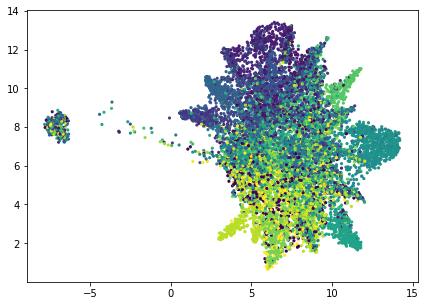

In [ ]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
from gensim.corpora import Dictionary
dictionary = Dictionary(texts)
from gensim.models import CoherenceModel, LdaModel, LsiModel, nmf
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [ ]:
coherence_model_lsa = CoherenceModel(model=lsimodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('\nCoherence Score: ', coherence_lsa)


Coherence Score:  0.49164512260413645


#nmf Topic Modeling

In [ ]:
!pip install spacy
!pip install textacy

     |████████████████████████████████| 215kB 2.8MB/s 
     |████████████████████████████████| 143kB 8.6MB/s 
     |████████████████████████████████| 3.0MB 8.9MB/s 
     |████████████████████████████████| 481kB 20.3MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.7.2-cp36-cp36m-linux_x86_64.whl size=73000 sha256=08146b15e18267af5f464e24c936807a4aa9c7c26320df89d25195bd531c96ff
  Stored in directory: /root/.cache/pip/wheels/e8/fe/99/d8fa8f2ef7b82a625b0b77a84d319b0b50693659823c4effb4
  Created wheel for cytoolz: filename=cytoolz-0.10.1-cp36-cp36m-linux_x86_64.whl size=1257042 sha256=0af29f9f8d90598e5fd6a33224542f4d2ae68b2820273ff0a1ea3e4b33a341f1
  Stored in directory: /root/.cache/pip/wheels/64/2a/18/d962b614e055577e7d9a3e4813e0742f822ca9c8800cc3783a
Successfully built jellyfish cytoolz


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.4MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=ea843e98236a0c4cab918756de1f2f5ab3d3a8d205f971b3221ebc359262fb2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ylrjp3l7/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
categories = ['alt.atheism', 'soc.religion.christian'] 
 
#Loading the data set - training data.
from sklearn.datasets import fetch_20newsgroups
  
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, categories=categories, remove=('headers', 'footers', 'quotes'))
  
# You can check the target names (categories) and some data files by following commands.
print (newsgroups_train.target_names) #prints all the categories
print("\n".join(newsgroups_train.data[0].split("\n")[:3])) #prints first line of the first data file
print (newsgroups_train.target_names)
print (len(newsgroups_train.data))

['alt.atheism', 'soc.religion.christian']
Library of Congress to Host Dead Sea Scroll Symposium April 21-22
 To: National and Assignment desks, Daybook Editor
 Contact: John Sullivan, 202-707-9216, or Lucy Suddreth, 202-707-9191
['alt.atheism', 'soc.religion.christian']
1079


In [ ]:
texts = []
  
labels=newsgroups_train.target
texts = newsgroups_train.data

import nltk; nltk.download('stopwords')
 
from nltk.corpus import stopwords
 
import textacy
from textacy.vsm import Vectorizer
terms_list=[[tok  for tok in doc.split() if tok not in stopwords.words('english') ] for doc in texts]
  
 
count=0           
for doc in terms_list:
 for word in doc:   
   print (word) 
   if word == "|>" or word == "|>" or word == "_" or word == "-" or word == "#":
         terms_list[count].remove (word)
   if word == "=":
         terms_list[count].remove (word)
   if word == ":":
         terms_list[count].remove (word)    
   if word == "_/":
         terms_list[count].remove (word)  
   if word == "I" or word == "A":
         terms_list[count].remove (word)
   if word == "The" or word == "But" or word=="If" or word=="It":
         terms_list[count].remove (word)       
 count=count+1
       

Streaming output truncated to the last 5000 lines.
Do
know
:
Point
Mutations
are?
Do
know
EVERYTHING
CAN
COME
:
ABOUT
SPONTANEOUSLY?!!!!!
:
In
response
last
statement,
no,
neither
you.
:
may
well
believe
accept
fact,
:
*know*
that.
I
forget
this:
We
_evidence_
suggests
everything
come
spontaneously.
Do
evidence
conclusion?
In
science,
one
_believe_
anything.
It
sign
doubt
disbelieve.
But
path
walk
take
look
evidence
so,
present
one's
conclusions
prior
this.
Theology
use
method.
Therefore,
I
doubt
could
ever
come
right
conclusions.
:
DNA,
"complex",
tends
accumulate
errors
adversely
:
well-being
ability
fight
disease,
:
DNA
bacteria
viruses
tend
become
efficient
:
infection
disease.
It
combination.
Hence
:
newborns
suffer
genetic,
viral,
bacterial
:
You
supposing
purpose,
valid
move.
Bacteria
viruses
exist
cause
disease.
They
another
manifests
general
principle
evolution
-
saves
replicators
degradiation.
We
efficient
method
DNA
survive
replicate.
The
efficient
methods
make
present.
And


In [ ]:
vectorizer = Vectorizer(tf_type='linear', apply_idf=True, idf_type='smooth')
doc_term_matrix = vectorizer.fit_transform(terms_list)
print ("========================doc_term_matrix)=======================")
print (doc_term_matrix)
 

========================doc_term_matrix)=======================
  (0, 2582)	7.29156913955832
  (0, 3132)	7.29156913955832
  (0, 5615)	7.29156913955832
  (0, 7896)	5.787491742782046
  (0, 4004)	6.19295685089021
  (0, 31839)	6.886104031450156
  (0, 14883)	6.886104031450156
  (0, 24893)	4.113515309210374
  (0, 29277)	7.29156913955832
  (0, 20585)	4.765840495250065
  (0, 6103)	3.257328501405925
  (0, 3860)	6.886104031450156
  (0, 8109)	7.29156913955832
  (0, 2532)	6.886104031450156
  (0, 9215)	7.29156913955832
  (0, 4382)	7.29156913955832
  (0, 6880)	7.29156913955832
  (0, 2784)	6.886104031450156
  (0, 5235)	14.58313827911664
  (0, 4733)	7.29156913955832
  (0, 7872)	6.886104031450156
  (0, 7389)	7.29156913955832
  (0, 9432)	7.29156913955832
  (0, 354)	7.29156913955832
  (0, 4379)	7.29156913955832
  :	:
  (1078, 16076)	4.89367386675995
  (1078, 9420)	4.58351893845611
  (1078, 24380)	3.4521168269650095
  (1078, 14063)	14.966952139692824
  (1078, 14050)	3.7950615780918397
  (1078, 4752)	4.321

In [ ]:
#initialize and train a topic model:
import textacy.tm
model = textacy.tm.TopicModel('nmf', n_topics=20)
model.fit(doc_term_matrix)
 
print ("======================model=================")
print (model)

======================model=================
TopicModel(n_topics=20, model=NMF)


In [ ]:
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, topics=[0,1]):
          print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : Jesus   Matthew   G'd   But,   prophecy   psalm   Matthew's   Israel   G'd.   [Mt
topic 1 : atheists   religious   atheism   God   many   believe   religion   belief   sort   Some


0 0.037204267948586736
1 0.05319374960355305
2 0.04013943002741619
3 0.04210371552912688
4 0.0241339959421475
5 0.042066348045016834
6 0.029213451539575178
7 0.22991558889395555
8 0.018881254313402377
9 0.03291245688808877
10 0.0617314461489939
11 0.030210456008884324
12 0.03127956413195796
13 0.049837041483976684
14 0.04809482787910448
15 0.024677222671460945
16 0.029027833601349296
17 0.05426677377087113
18 0.04064351992560471
19 0.08046705564692778
doc_term_matrix
  (0, 290)	7.29156913955832
  (0, 354)	7.29156913955832
  (0, 366)	7.29156913955832
  (0, 367)	7.29156913955832
  (0, 386)	7.29156913955832
  (0, 425)	24.807412310449244
  (0, 1356)	7.29156913955832
  (0, 2168)	4.9889840465642745
  (0, 2529)	31.468275747865068
  (0, 2532)	6.886104031450156
  (0, 2582)	7.29156913955832
  (0, 2753)	6.598421958998375
  (0, 2784)	6.886104031450156
  (0, 2797)	5.90527477843843
  (0, 2848)	6.19295685089021
  (0, 2987)	6.038806171062952
  (0, 3001)	7.29156913955832
  (0, 3088)	7.29156913955832
  

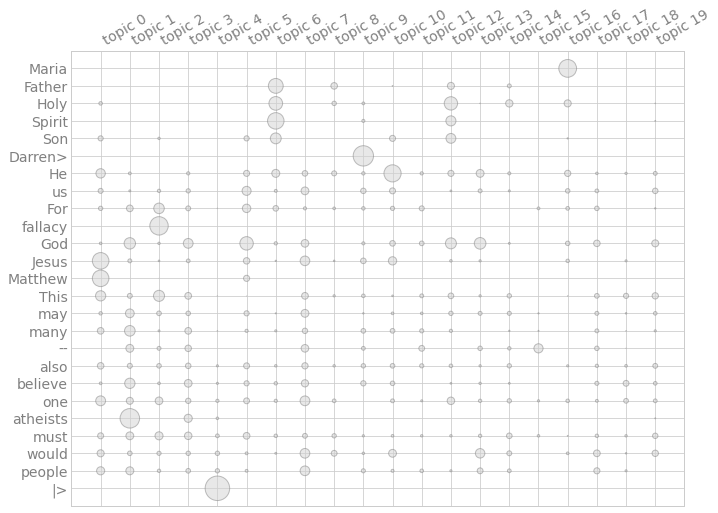

In [ ]:
for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
     print(i, val)
      
      
print   ("doc_term_matrix")     
print   (doc_term_matrix)   
print ("vectorizer.id_to_term")
print (vectorizer.id_to_term)
          
 
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, topics=-1,  n_terms=25, sort_terms_by='seriation')  
model.save('nmf-10topics.pkl')        